In [3]:
root = '../'

import os, sys
from skimage import io, transform
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd

from functools import cmp_to_key

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import mask_rcnn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

In [37]:
# Basic settings
# Basic settings
torch.manual_seed(470)
torch.cuda.manual_seed(470)

#!pip install easydict
from easydict import EasyDict as edict

args = edict()
args.batch_size = 2
args.nlayers = 2

args.embedding_size = 4
args.ninp = 4 + args.embedding_size
args.nhid = 256 #512


args.clip = 1
args.lr_lstm = 0.001
args.dropout = 0.2
args.nhid_attn = 256
args.epochs = 20

##### Transformer
args.nhid_tran = 256
args.nhead = 8
args.nlayers_transformer = 6
args.attn_pdrop = 0.1
args.resid_pdrop = 0.1
args.embd_pdrop = 0.1
args.nff = 4 * args.nhid_tran


args.lr_transformer = 0.0001 #1.0
args.betas = (0.9, 0.98)

args.gpu = True

args.tensorboard = False
args.train_portion = 0.7
args.slide_deck_N = 5
args.slide_deck_embedding_size = 512
args.padding_idx = 0


# Decoder
args.latent_vector_dim = 28
args.hidden_size = 64
args.dropout_rate = 0.5

device = 'cuda:0' if torch.cuda.is_available() and args.gpu else 'cpu'
# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)


BB_TYPES = [
    '<pad>',
    'title',
    'header',
    'text box',
    'footer',
    'picture',
    'instructor',
    'diagram',
    'table',
    'figure',
    'handwriting',
    'chart',
    'schematic diagram',
]

In [5]:
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "{str(result_dir)}" --samples_per_plugin images=100

In [6]:
def draw_bbs(shape, bbs):
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())
    if (torch.is_tensor(shape)):
        [h, w] = np.array(shape.tolist())
        shape = (h, w)
    
    h, w = shape
    fig, ax = plt.subplots(1)
    background=patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor='b', facecolor='black')
    ax.add_patch(background)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.autoscale(True, 'both')
    plt.show()
    return

def get_BB_types(bbs):
    return bbs[:, 4]

class BBSlideDeckDataset(Dataset):
    """ Slide Deck Dataset but with Bounding Boxes"""
    def __init__(self, slide_deck_data, transform=None):
        self.transform = transform

        self.slide_deck_data = slide_deck_data
        self.slide_deck_ids = list(self.slide_deck_data.keys())
    
    def __len__(self):
        return len(self.slide_deck_ids)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        slide_deck_id = self.slide_deck_ids[idx]
        (h, w) = self.slide_deck_data[slide_deck_id]["shape"]
        lengths_slide_deck = []
        slides = []
        max_len_bbs = 0
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            lengths_slide_deck.append(len(slide))
            if len(slide) > max_len_bbs:
                max_len_bbs = len(slide)
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            np_slide = np.zeros((max_len_bbs, 5), dtype=np.double)
            for i, bb in enumerate(slide):
                np_slide[i] = bb
            slides.append(np_slide)

        ref_slide = slides[0]
        slide_deck = slides[1:]
        length_ref_types = lengths_slide_deck.pop(0)
        sample = {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": get_BB_types(ref_slide),
            "slide_deck": np.asarray(slide_deck),
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

        if self.transform:
            sample = self.transform(sample)
        return sample


In [7]:
class RescaleBB(object):
    """Rescale the bounding boxes in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def _resize_single_slide(self, slide, original_shape, new_shape):
        h, w = original_shape
        new_h, new_w = new_shape
        slide = slide * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return slide

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        ref_slide = self._resize_single_slide(ref_slide, (h, w), (new_h, new_w))
        for i, slide in enumerate(slide_deck):
            slide_deck[i] = self._resize_single_slide(slide, (h, w), (new_h, new_w))

        return {
            "shape": (new_h, new_w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class LeaveN(object):
    def __init__ (self, N):
        self.N = N

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if slide_deck.shape[0] > self.N:
            slide_deck = np.delete(slide_deck, range(self.N, slide_deck.shape[0]), 0)
            lengths_slide_deck = lengths_slide_deck[:self.N]

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ShuffleRefSlide(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        lengths_slide_deck.append(length_ref_types)
        slide_deck = np.vstack((slide_deck, ref_slide[None, :]))

        idxs = np.array([*range(0, len(lengths_slide_deck))], dtype=np.int32)
        np.random.shuffle(idxs)

        slide_deck = slide_deck[idxs]

        lengths_slide_deck = np.array(lengths_slide_deck, dtype=np.int32)
        lengths_slide_deck = lengths_slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck.tolist()
        
        slide_deck = slide_deck.tolist()
        ref_slide = np.asarray(slide_deck.pop())
        length_ref_types = lengths_slide_deck.pop()
        ref_types = get_BB_types(ref_slide)

        slide_deck = np.asarray(slide_deck)
        
        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ToTensorBB(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        idxs = [*range(0, len(lengths_slide_deck))]

        def by_length(p1, p2):
            return lengths_slide_deck[p2] - lengths_slide_deck[p1]
        idxs = sorted(idxs, key=cmp_to_key(by_length))

        shape = torch.tensor([h, w], dtype=torch.float64)
        ref_slide = torch.from_numpy(ref_slide).float()
        ref_types = torch.from_numpy(ref_types).float()
        
        slide_deck = torch.from_numpy(slide_deck).float()
        lengths_slide_deck = torch.tensor(lengths_slide_deck, dtype=torch.int32)
        
        slide_deck = slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck[idxs]

        length_ref_types = torch.tensor(length_ref_types, dtype=torch.int32)

        return {
            "shape": shape,
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types
        }

In [8]:
def process_slide_deck_dataset(all_dataset):
    slide_deck_data = {}
    for entrance in all_dataset.iloc:
        slide_deck_id = entrance['Slide Deck Id']
        
        slide_id = entrance["Slide Id"]
        if (slide_deck_id not in slide_deck_data):
            slide_deck_data[slide_deck_id] = {
                'slides': {},
                'shape': (entrance['Image Height'], entrance['Image Width'])
            }
        
        if slide_id not in slide_deck_data[slide_deck_id]["slides"]:
            slide_deck_data[slide_deck_id]["slides"][slide_id] = []
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type
        ]).T
        slide_deck_data[slide_deck_id]['slides'][slide_id].append(bb)
    for key in slide_deck_data.keys():
        
        # if key == 100:
        #     for (id, value) in slide_deck_data[key]["slides"].items():
        #         print(56, id)
        #         draw_bbs(slide_deck_data[key]["shape"], value)

        values = list(slide_deck_data[key]["slides"].values())
        slide_deck_data[key]["slides"] = [np.asarray(value) for value in values]
    return slide_deck_data

def slice_dict(dictionary, l, r):
    keys = list(dictionary.keys())
    keys = keys[l:r]
    ret_dictionary = {}
    for key in keys:
        ret_dictionary[key] = dictionary[key]
    return ret_dictionary

In [9]:
csv_file = os.path.join(os.path.dirname(os.getcwd()), "data", "slide_deck_dataset.csv")

dataset = pd.read_csv(csv_file)
slide_deck_data = process_slide_deck_dataset(dataset)

division = int(args.train_portion * len(slide_deck_data))

train_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, 0, division),
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        LeaveN(args.slide_deck_N),
        ToTensorBB()
    ])
)

test_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, division, len(slide_deck_data)),
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        LeaveN(args.slide_deck_N),
        ToTensorBB()
    ])
)


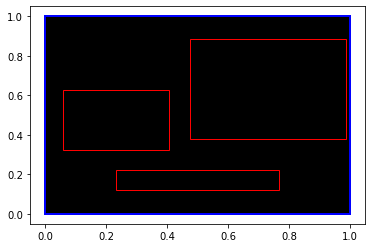

tensor([11.,  3.,  1.,  0.,  0.,  0.,  0.])
tensor([[0.2473, 0.1190, 0.5074, 0.1069, 1.0000],
        [0.0578, 0.4118, 0.4015, 0.0685, 3.0000],
        [0.0586, 0.5060, 0.4004, 0.2107, 3.0000],
        [0.0575, 0.3216, 0.2919, 0.0670, 3.0000],
        [0.5274, 0.3241, 0.4178, 0.4476, 7.0000],
        [0.0575, 0.5025, 0.4026, 0.2923, 3.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.0571, 0.3196, 0.7879, 0.1593, 3.0000],
        [0.0586, 0.1159, 0.8851, 0.1144, 1.0000],
        [0.0548, 0.5131, 0.8529, 0.1618, 3.0000],
        [0.0537, 0.5156, 0.8560, 0.2646, 3.0000],
        [0.0571, 0.7021, 0.7792, 0.0796, 3.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor([[0.2261, 0.1210, 0.5509, 0.1033, 1.0000],
        [0.0514, 0.9138, 0.8594, 0.0418, 3.0000],
        [0.0586, 0.6568, 0.8321, 0.2001, 9.0000],
        [0.0597, 0.4229, 0.1728, 0.0600, 3.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    

In [10]:
single = train_slide_deck_dataset[0]
draw_bbs(single["shape"], single["ref_slide"])

print(single["ref_types"])
for i in range(5):
    print(single["slide_deck"][i])
print(single["lengths_slide_deck"])

In [31]:
train_loader = DataLoader(train_slide_deck_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_slide_deck_dataset, batch_size=args.batch_size, shuffle=True)

In [12]:
class SlideEncoder(nn.Module):
    def __init__(self):
        super(SlideEncoder, self).__init__()
        ninp = args.ninp
        nhid = args.nhid
        nlayers = args.nlayers
        dropout = args.dropout
        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, args.padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(ninp, nhid, nlayers, bias=True).float()

    def forward(self, x, states, lengths=None):
        """
        Args:
            x: tensor(B, L, 5)
            states: List[Tuple(h_0, c_0), ..., Tuple(h_{B-1}, c_{B-1})]
            lengths: tensor(B)
        """
        idxs = [*range(0, len(lengths))]
        def by_lengths(p1, p2):
            return lengths[p2] - lengths[p1]

        idxs = sorted(idxs, key=cmp_to_key(by_lengths))

        x = x[:, idxs]
        lengths = lengths[idxs]
        
        input = x[:, :, :-1]
        types = x[:, :, -1:].long()
        types = torch.squeeze(self.embed(types))
        input = torch.cat((input, types), dim=-1)

        h_0 = torch.stack([h for (h, _) in states], dim=0)
        c_0 = torch.stack([c for (_, c) in states], dim=0)
        
        output = self.dropout(input)
        (output, context_vector) = self.lstm(output, (h_0, c_0))
        return (output, context_vector)

class SlideDeckEncoder(nn.Module):
    def __init__(self):
        super(SlideDeckEncoder, self).__init__()
        self.slide_encoder = SlideEncoder()

        input_size = args.nhid * args.slide_deck_N
        output_size = args.slide_deck_embedding_size

        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        return

    def _get_init_states(self, x):
        init_states = [
            (torch.zeros((x.size(1), args.nhid)).to(x.device),
            torch.zeros((x.size(1), args.nhid)).to(x.device))
            for _ in range(args.nlayers)
        ]
        return init_states
    
    def forward(self, xs, lengths):
        states = None
        embedding = []
        for i, x in enumerate(xs):
            if states is None:
                states = self._get_init_states(x)
            length = lengths[i]
            output, states = self.slide_encoder(x, states, length)
            embedding.append(output[-1:].squeeze())
        
        output = torch.cat(embedding, dim=-1)
        output = self.relu(self.linear(output))
        return output

In [62]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, torch.autograd.Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return torch.autograd.Variable(y_one_hot) if isinstance(y, torch.autograd.Variable) else y_one_hot

class Generator(nn.Module):
    def __init__(self, embed_weights=None, ganlike=True):
        super(Generator, self).__init__()
        self.ganlike = ganlike
        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, padding_idx=0)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=args.latent_vector_dim + args.embedding_size, hidden_size=args.hidden_size, num_layers=2, 
            batch_first=True, dropout=args.dropout_rate, bias=True)
        self.linear1 = nn.Linear(args.slide_deck_embedding_size, args.hidden_size)
        self.linear2 = nn.Linear(args.hidden_size, 4)
        if embed_weights:
            self.embed.weight = embed_weights
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.gen_model = nn.Sequential(
            *block(args.hidden_size, 32, normalize=False),
            *block(32, 32),
            nn.Linear(32, 4),
            nn.Tanh()
        )


    def forward(self, x, z, slide_deck_embedding, length=None):
        """

        Args:
            x (tensor): bb labels, (Batch_size, Sequence_size)
            z (tensor): latent vector, (Batch_size, latent_vector_dim)
            slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            length (tensor): (Batch_size,)

        Returns:
            bb sequence: (tensor), (Batch_size, Sequence_size, 5)
        """
        # print(x.shape, z.shape, slide_deck_embedding.shape)
        x = x.int()
        (Batch_size, Sequence_size) = x.shape
        temp_input_1 = self.dropout(self.embed(x))   # Batch_size, Sequence_size, input_size
        # print("1",temp_input_1.shape)
        temp_input_2 = z.unsqueeze(1).repeat((1, Sequence_size, 1))
        # print("2",temp_input_2.shape)
        input_1 = torch.cat((temp_input_2, temp_input_1), dim=-1)
        # print("3",input_1.shape)
        hidden_0 = self.dropout(self.linear1(slide_deck_embedding)).unsqueeze(0).repeat((2, 1, 1))
        # print("4",hidden_0.shape)
        c_0 = torch.zeros(size=(2,Batch_size, args.hidden_size))
        # print("5",c_0.shape)
        output, (h_n, c_n) = self.lstm(input_1, (hidden_0, c_0))
        # print("6",output.shape)
        # output = output.transpose(0, 1)
        if self.ganlike:
            output = self.gen_model(output)
        else:
            output = self.linear2(output)

        return output, (h_n, c_n)

In [71]:
print(args.batch_size)
mydec = Decoder()
z = torch.randn((args.batch_size, args.latent_vector_dim))
s = list(train_loader)[0]
# print(len(s))
# for sl in s:
#     print(sl)
#     print(s[sl].shape)
v = mydec(x=s['ref_types'], z=z, slide_deck_embedding=torch.randn((args.batch_size, args.slide_deck_embedding_size)))
# draw_bbs(,)
v[0].size()

2
torch.Size([2, 7]) torch.Size([2, 28]) torch.Size([2, 512])
1 torch.Size([2, 7, 4])
2 torch.Size([2, 7, 28])
3 torch.Size([2, 7, 32])
4 torch.Size([2, 2, 64])
5 torch.Size([2, 2, 64])
6 torch.Size([2, 7, 64])


torch.Size([2, 7, 4])

In [57]:
model = SlideDeckEncoder()

for epoch in range(args.epochs):
    for batch in train_loader:
        xs = torch.transpose(batch["slide_deck"], 0, 1)
        xs = torch.transpose(xs, 1, 2)
        lengths = torch.transpose(batch["lengths_slide_deck"], 0, 1)
        slide_deck_embedding = model(xs, lengths)
        print(slide_deck_embedding.shape)


torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 512])


In [90]:
class Discriminator(nn.Module):
    def __init__(self, embed_weights=None):
        super(Discriminator, self).__init__()

        self.embed = nn.Embedding(len(BB_TYPES), args.embedding_size, padding_idx=0)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=4 + args.embedding_size, hidden_size=args.hidden_size, num_layers=2, 
            batch_first=True, dropout=args.dropout_rate, bias=True)
        self.linear1 = nn.Linear(args.slide_deck_embedding_size, args.hidden_size)
        self.d_model = nn.Sequential(
            nn.Linear(args.hidden_size, args.hidden_size//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(args.hidden_size//2, args.hidden_size//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(args.hidden_size//2, 1)
        )
        if embed_weights:
            self.embed.weight = embed_weights


    def forward(self, x, bb, slide_deck_embedding, length=None):
        """

        Args:
            x (tensor): type labels, (Batch_size, Sequence_size)
            bb (tensor): (Batch_size, Sequence_size, 4)
            z (tensor): latent vector, (Batch_size, latent_vector_dim)
            slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            length (tensor): (Batch_size,)

        Returns:
            bb sequence: (tensor), (Batch_size, Sequence_size, 5)
        """
        print(x.shape, z.shape, slide_deck_embedding.shape)
        x = x.int()
        (Batch_size, Sequence_size) = x.shape
        temp_input_1 = self.dropout(self.embed(x))   # Batch_size, Sequence_size, input_size
        # print("1",temp_input_1.shape)
        # temp_input_2 = z.unsqueeze(1).repeat((1, Sequence_size, 1))
        input_1 = torch.cat((bb, temp_input_1), dim=-1)
        # print("3",input_1.shape)
        hidden_0 = self.dropout(self.linear1(slide_deck_embedding)).unsqueeze(0).repeat((2, 1, 1))
        # print("4",hidden_0.shape)
        c_0 = torch.zeros(size=(2,Batch_size, args.hidden_size))
        # print("5",c_0.shape)
        output, (h_n, c_n) = self.lstm(input_1, (hidden_0, c_0))
        print("6",output.shape)
        print(output[:,-1,:])
        # output = output.transpose(0, 1)
        output = self.d_model(output[:,-1,:].squeeze())
         
        return output

In [91]:
c = Discriminator()


In [92]:
z = torch.randn((args.batch_size, args.latent_vector_dim))
s = list(train_loader)[0]
# print(len(s))
# for sl in s:
#     print(sl)
#     print(s[sl].shape)
sss = c(x=s['ref_types'], bb = v[0], slide_deck_embedding=torch.randn((args.batch_size, args.slide_deck_embedding_size)))


torch.Size([2, 7]) torch.Size([2, 28]) torch.Size([2, 512])
6 torch.Size([2, 7, 64])
tensor([[-0.0369,  0.0152, -0.0134, -0.0736,  0.0297,  0.0369, -0.0283, -0.0368,
          0.0693, -0.0568,  0.0247, -0.0116,  0.0671, -0.0436,  0.0901, -0.0108,
          0.0211, -0.0332, -0.0460, -0.0927, -0.0605, -0.0951,  0.0383, -0.0676,
          0.0182, -0.0348,  0.0248, -0.0497,  0.0169, -0.0360,  0.0566, -0.0510,
          0.0675, -0.0192,  0.0164,  0.0772,  0.0762, -0.0456,  0.0245, -0.0271,
          0.0516,  0.0143, -0.0822,  0.0743, -0.0027,  0.0640, -0.0420, -0.0251,
         -0.0751,  0.0302,  0.0261, -0.0058,  0.0213, -0.0170,  0.0176, -0.0222,
          0.0724, -0.0250,  0.0201,  0.0242, -0.0269, -0.0902,  0.0772,  0.0631],
        [-0.0378, -0.0062, -0.0261, -0.0748,  0.0285,  0.0172, -0.0238, -0.0285,
          0.0542, -0.0719,  0.0397, -0.0218,  0.0642, -0.0374,  0.1012, -0.0067,
          0.0376, -0.0297, -0.0259, -0.0756, -0.0249, -0.0895,  0.0321, -0.0891,
          0.0268, -0.02

In [89]:
sss

tensor([[-0.1806],
        [-0.1812]], grad_fn=<AddmmBackward>)